In [24]:

import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from collections import Counter

import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize


from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score, classification_report
)



In [25]:
# # ---------------------------
# # Parameters and Setup
# # ---------------------------
# # %% [markdown]
# # ## Parameter Definition
# # You can later inject these parameters via Papermill if desired.
# dataset_path = "/Users/book_kuno/Desktop/ddos_datasets/2018.csv"  # Update path as needed
# sample_fraction = 0.05  # Use 1 for 100% of data (change to e.g., 0.05 for 5%)
# run_name = "1d-cnn-100percent"  # Change as desired
# year = "2018"
# model = "1DCNN"  # Change as desired

# # Define output folder and create it
# output_folder = os.path.join("Outputs", year, model, run_name)
# os.makedirs(output_folder, exist_ok=True)
# print("Output folder created:", output_folder)

# # %% [markdown]
# # ## Parameter Definition
# # You can later inject these parameters via Papermill if desired.
# dataset_path = "/Users/book_kuno/Desktop/ddos_datasets/2018.csv"  # Update path as needed
# sample_fraction = 0.05  # Use 1 for 100% of data (change to e.g., 0.05 for 5%)
# run_name = "logreg_run1-100percent"  # Change as desired
# year = "2018"
# model = "logreg"  # Change as desired

# # Define output folder and create it if needed
# output_folder = os.path.join("Outputs", year, model, run_name)
# os.makedirs(output_folder, exist_ok=True)
# print("Output folder created:", output_folder)

import os

# 1. Parameters and Setup
dataset_path = "/Users/book_kuno/Desktop/Final/ML_System/datasets/2018.csv"  # Update path as needed
sample_fraction = 0.5  # Use 1 for 100% of data (change to e.g., 0.05 for 5%)
run_name = "1dcnn_run1-0_5percent"  # Change as desired
model = "1dcnn"  # Change as desired

# Extract the entire filename (without the extension) from the dataset_path.
filename = os.path.basename(dataset_path)  # e.g., "2018.csv"
csv_name = os.path.splitext(filename)[0]    # e.g., "2018" or "MyDataset" if the file is named that way

# Use csv_name as the dynamic folder name
output_folder = os.path.join("outputs", csv_name, model, run_name)
os.makedirs(output_folder,   exist_ok=True)
print("Output folder created:", output_folder)


Output folder created: outputs/2018/1dcnn/1dcnn_run1-0_5percent


In [26]:
# ---------------------------
# 2. Data Loading & Preprocessing
# ---------------------------
data_full = pd.read_csv(dataset_path, delimiter=',', header=0)
print("Original dataset shape:", data_full.shape)
print("First few rows:")
print(data_full.head())
print("\nDataset info:")
print(data_full.info())
print("\nClass distribution:")
print(data_full['label'].value_counts())

# Sample a fraction of the dataset
data = data_full.sample(frac=sample_fraction, random_state=42).reset_index(drop=True)
print(f"Dataset shape after sampling {sample_fraction*100:.0f}%:", data.shape)

# Remove unwanted rows (e.g. rows where the header was misread as data)
data = data[data['label'] != 'Label']

/var/folders/r9/g1ll_nxx2n70f0475ch9wkyr0000gn/T/ipykernel_77736/2942695512.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data_full = pd.read_csv(dataset_path, delimiter=',', header=0)


Original dataset shape: (4339651, 26)
First few rows:
    timestamp  Dst Port protocol  Flow Duration  Flow Duration_rolling_mean  \
0  1518745716   55250.0      6.0       958807.0                   1815614.1   
1  1519099848     443.0      6.0      6081730.0                   2284039.7   
2  1519179901   52453.0      6.0         1428.0                      6703.5   
3  1518659728    3389.0      6.0      2169521.0                   9191415.4   
4  1519116456   49913.0      6.0           97.0                  24709922.5   

   Flow Duration_rolling_std  Tot Fwd Pkts  Tot Bwd Pkts  TotLen Fwd Pkts  \
0               1.965582e+06           5.0           3.0            935.0   
1               2.888929e+06          10.0          12.0            646.0   
2               8.135168e+03           5.0           2.0            935.0   
3               2.752269e+07           8.0           7.0           1132.0   
4               4.818137e+07           3.0           1.0             31.0   

   TotLe

In [27]:
# ---------------------------
# 3. Label Encoding
# ---------------------------
# Encode labels using factorize (this converts strings to integer codes)
data['label'], uniques = pd.factorize(data['label'])
# Create a mapping from integer code to original label for reference
label_names = {i: label for i, label in enumerate(uniques)}
print("Encoded labels mapping:")
print(label_names)

Encoded labels mapping:
{0: 'Benign', 1: 'DoS attacks-Hulk', 2: 'DDoS attacks-LOIC-HTTP', 3: 'DDOS attack-HOIC', 4: 'DoS attacks-SlowHTTPTest', 5: 'DoS attacks-GoldenEye', 6: 'DoS attacks-Slowloris', 7: 'DDOS attack-LOIC-UDP'}


In [28]:
# ---------------------------
# 4. Feature Selection & Standardization
# ---------------------------
# Select features: choose all columns except 'timestamp' and 'label'
selected_features = [col for col in data.columns if col.lower() not in ['timestamp', 'protocol', 'label']]
print("Selected features:")
print(selected_features)

# Extract features and labels, and reset index for safety
X = data[selected_features].reset_index(drop=True)
y = data['label'].reset_index(drop=True)

# Handle missing values
num_rows_before = X.shape[0]
X = X.dropna()
num_rows_after = X.shape[0]
print("Number of rows dropped due to missing values:", num_rows_before - num_rows_after)

# (Optional) --- Clean specific columns like 'protocol' if necessary ---
# For example, if the 'protocol' column has non-numeric values, convert them:
# data['protocol_numeric'] = pd.to_numeric(data['protocol'], errors='coerce')
# data = data.dropna(subset=['protocol_numeric'])
# data['protocol'] = data['protocol_numeric'].astype(int)
# data = data.drop(columns=['protocol_numeric'])

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
scaler_path = os.path.join(output_folder, "scaler.pkl")
joblib.dump(scaler, scaler_path)
print("Scaler saved at:", scaler_path)


Selected features:
['Dst Port', 'Flow Duration', 'Flow Duration_rolling_mean', 'Flow Duration_rolling_std', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Min', 'SYN Flag Cnt', 'pkts_ratio', 'byte_per_duration', 'entropy_pkt_len', 'Subflow Fwd Byts', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min']
Number of rows dropped due to missing values: 0
Scaler saved at: outputs/2018/1dcnn/1dcnn_run1-0_5percent/scaler.pkl


In [29]:
# ---------------------------
# 5. Train-Test-Validation Split
# ---------------------------
# Split data into 70% train, 15% validation, and 15% test using stratified splitting
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42, stratify=data['label'])
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['label'])

def extract_features_labels(df, features, label_col='label'):
    X = df[features].values
    y = df[label_col].values
    return X, y

X_train, y_train = extract_features_labels(train_data, selected_features)
X_val, y_val = extract_features_labels(val_data, selected_features)
X_test, y_test = extract_features_labels(test_data, selected_features)

# Standardize splits using the same scaler
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [30]:
# --------------------------- $$$$$$$$
# 6. Create PyTorch Dataset and DataLoaders
# ---------------------------
batch_size = 128

class DDoSDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        # For 1D CNN, add a channel dimension (1, num_features)
        return self.features[idx].unsqueeze(0), self.labels[idx]

# Create dataset instances
train_dataset = DDoSDataset(X_train, y_train)
val_dataset = DDoSDataset(X_val, y_val)
test_dataset = DDoSDataset(X_test, y_test)

# Handle class imbalance using WeightedRandomSampler
train_class_counts = Counter(y_train)
train_class_weights = {cls: 1.0 / count for cls, count in train_class_counts.items()}
train_weights = [train_class_weights[label] for label in y_train]
sampler = WeightedRandomSampler(train_weights, num_samples=len(train_weights), replacement=True)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [31]:
# ---------------------------
# 7. Define the 1D CNN Model (PyTorch)
# ---------------------------
class CNN1D(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.3)
        # Calculate reduced feature size after 3 pooling layers (each halves the feature dimension)
        reduced_size = input_size // 8
        self.fc1 = nn.Linear(128 * reduced_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)), 0.01))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x)), 0.01))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x)), 0.01))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.leaky_relu(self.fc1(x), 0.01))
        x = self.dropout(F.leaky_relu(self.fc2(x), 0.01))
        x = self.fc3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = X_train.shape[1]
num_classes = len(label_names)  # Based on encoded labels
model = CNN1D(input_size, num_classes).to(device)

# Xavier Initialization
def init_weights(m):
    if isinstance(m, (nn.Conv1d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [32]:
# --------------------------- $$$$$$$$
# 8. Training Loop with Early Stopping and Epoch Time Calculation
# ---------------------------
num_epochs = 50
patience = 5  # Number of epochs to wait for improvement
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_wts = None

for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time of the epoch

    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_X.size(0)
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

    epoch_loss = train_loss / total
    epoch_acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.4f}")

    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item() * batch_X.size(0)
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    val_loss /= total
    val_acc = correct / total
    print(f"Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_acc:.4f}")

    # Check if validation loss has improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = model.state_dict()  # Save the best model weights
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # If validation loss hasn't improved for 'patience' epochs, stop early
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

    # Record the end time of the epoch and compute the duration
    end_time = time.time()
    epoch_duration = end_time - start_time
    print(f"Epoch {epoch+1} completed in {epoch_duration:.2f} seconds")

# Load the best model weights after training
if best_model_wts is not None:
    model.load_state_dict(best_model_wts)

# Save the best model into your output folder
best_model_path = os.path.join(output_folder, "best_model.pth")
torch.save(model.state_dict(), best_model_path)
print("Best model saved at:", best_model_path)

Epoch 1/50: Loss = 0.0375, Accuracy = 0.9882
Validation Loss = 0.0049, Validation Accuracy = 0.9990
Epoch 1 completed in 115.95 seconds
Epoch 2/50: Loss = 0.0026, Accuracy = 0.9994
Validation Loss = 0.0015, Validation Accuracy = 0.9995
Epoch 2 completed in 118.88 seconds
Epoch 3/50: Loss = 0.0020, Accuracy = 0.9995
Validation Loss = 0.0013, Validation Accuracy = 0.9996
Epoch 3 completed in 119.32 seconds
Epoch 4/50: Loss = 0.0018, Accuracy = 0.9996
Validation Loss = 0.0028, Validation Accuracy = 0.9993
Epoch 4 completed in 118.89 seconds
Epoch 5/50: Loss = 0.0015, Accuracy = 0.9997
Validation Loss = 0.0025, Validation Accuracy = 0.9993
Epoch 5 completed in 118.19 seconds
Epoch 6/50: Loss = 0.0013, Accuracy = 0.9997
Validation Loss = 0.0036, Validation Accuracy = 0.9994
Epoch 6 completed in 566.03 seconds
Epoch 7/50: Loss = 0.0012, Accuracy = 0.9997
Validation Loss = 0.0021, Validation Accuracy = 0.9995
Epoch 7 completed in 118.76 seconds
Epoch 8/50: Loss = 0.0012, Accuracy = 0.9997
Val

In [33]:
# ---------------------------
# 9. Evaluation on Validation Set
# ---------------------------
model.eval()
val_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        val_loss += loss.item() * batch_X.size(0)
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
val_loss /= total
val_acc = correct / total
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

Validation Loss: 0.0013, Validation Accuracy: 0.9996


In [34]:
# ---------------------------
# 10. Save Model and Artifacts
# ---------------------------
model_save_path = os.path.join(output_folder, "cnn1d_model.pth")
torch.save(model.state_dict(), model_save_path)
print("CNN model saved at:", model_save_path)

# Save evaluation metrics
eval_metrics_path = os.path.join(output_folder, "evaluation_metrics.txt")
with open(eval_metrics_path, "w") as f:
    f.write(f"Validation Loss: {val_loss:.4f}\n")
    f.write(f"Validation Accuracy: {val_acc:.4f}\n")
print("Evaluation metrics saved at:", eval_metrics_path)

CNN model saved at: outputs/2018/1dcnn/1dcnn_run1-0_5percent/cnn1d_model.pth
Evaluation metrics saved at: outputs/2018/1dcnn/1dcnn_run1-0_5percent/evaluation_metrics.txt


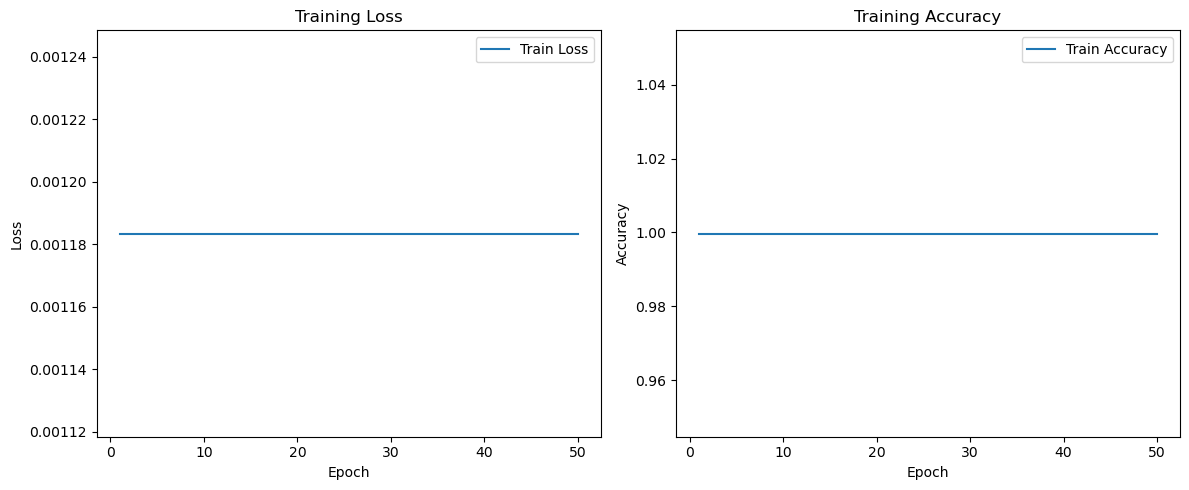

Training history plot saved at: outputs/2018/1dcnn/1dcnn_run1-0_5percent/training_history.png


In [35]:
# ---------------------------
# 11. Plot and Save Training History (if applicable)
# ---------------------------
# (For simplicity, we’re just plotting training loss/accuracy per epoch)
# In a real experiment, you might store epoch-level metrics in a list/dictionary.
# Here we assume the printed output is sufficient.
# You could also add code to log metrics and then plot them after training.

# Example: Save a dummy training history plot (if you were logging metrics)
epochs = np.arange(1, num_epochs + 1)
# (In practice, replace these with actual logged values)
train_losses = [epoch_loss for _ in epochs]
train_accuracies = [epoch_acc for _ in epochs]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

train_history_path = os.path.join(output_folder, "training_history.png")
plt.tight_layout()
plt.savefig(train_history_path, bbox_inches='tight')
plt.show()
print("Training history plot saved at:", train_history_path)

In [36]:
# ---------------------------
# 9. Evaluation on Validation Set
# ---------------------------
model.eval()
val_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        val_loss += loss.item() * batch_X.size(0)
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
val_loss /= total
val_acc = correct / total
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

Validation Loss: 0.0013, Validation Accuracy: 0.9996


In [37]:
# ---------------------------
# 10. Save Model and Artifacts
# ---------------------------
model_save_path = os.path.join(output_folder, "cnn1d_model.pth")
torch.save(model.state_dict(), model_save_path)
print("CNN model saved at:", model_save_path)

# Save evaluation metrics
eval_metrics_path = os.path.join(output_folder, "evaluation_metrics.txt")
with open(eval_metrics_path, "w") as f:
    f.write(f"Validation Loss: {val_loss:.4f}\n")
    f.write(f"Validation Accuracy: {val_acc:.4f}\n")
print("Evaluation metrics saved at:", eval_metrics_path)

CNN model saved at: outputs/2018/1dcnn/1dcnn_run1-0_5percent/cnn1d_model.pth
Evaluation metrics saved at: outputs/2018/1dcnn/1dcnn_run1-0_5percent/evaluation_metrics.txt


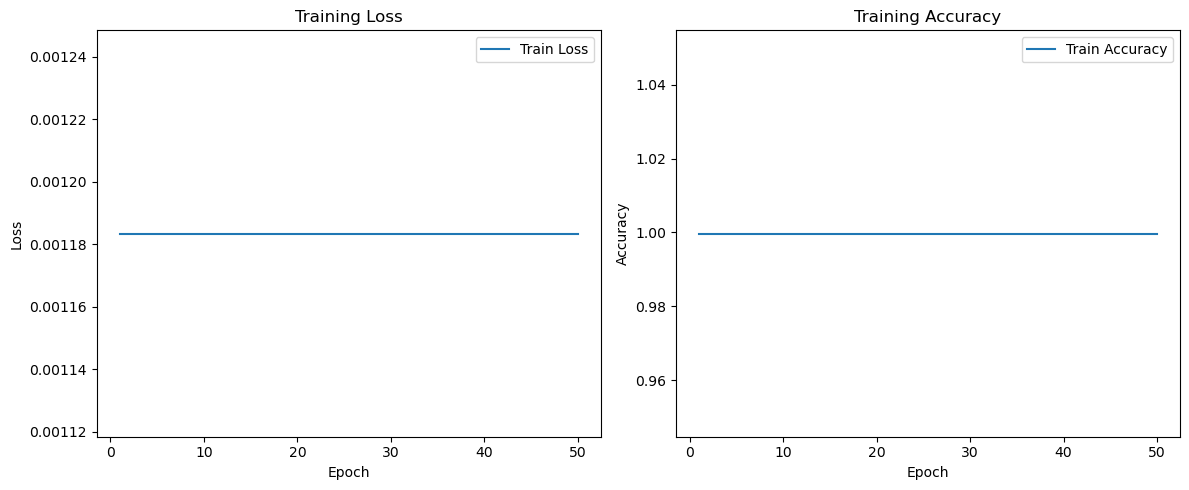

Training history plot saved at: outputs/2018/1dcnn/1dcnn_run1-0_5percent/training_history.png


In [38]:
# ---------------------------
# 11. Plot and Save Training History (if applicable)
# ---------------------------
# (For simplicity, we’re just plotting training loss/accuracy per epoch)
# In a real experiment, you might store epoch-level metrics in a list/dictionary.
# Here we assume the printed output is sufficient.
# You could also add code to log metrics and then plot them after training.

# Example: Save a dummy training history plot (if you were logging metrics)
epochs = np.arange(1, num_epochs + 1)
# (In practice, replace these with actual logged values)
train_losses = [epoch_loss for _ in epochs]
train_accuracies = [epoch_acc for _ in epochs]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

train_history_path = os.path.join(output_folder, "training_history.png")
plt.tight_layout()
plt.savefig(train_history_path, bbox_inches='tight')
plt.show()
print("Training history plot saved at:", train_history_path)

Classification Report:
                           precision    recall  f1-score   support

                  Benign     1.0000    0.9993    0.9996    180745
        DoS attacks-Hulk     0.9999    1.0000    1.0000     34750
  DDoS attacks-LOIC-HTTP     0.9998    0.9999    0.9998     43188
        DDOS attack-HOIC     1.0000    1.0000    1.0000     51401
DoS attacks-SlowHTTPTest     0.9999    1.0000    1.0000     10535
   DoS attacks-GoldenEye     0.9957    0.9987    0.9972      3729
   DoS attacks-Slowloris     0.9105    0.9990    0.9527       998
    DDOS attack-LOIC-UDP     1.0000    1.0000    1.0000       128

                accuracy                         0.9996    325474
               macro avg     0.9882    0.9996    0.9937    325474
            weighted avg     0.9996    0.9996    0.9996    325474

Confusion Matrix:
 [[180620      3     10      0      1     16     95      0]
 [     0  34750      0      0      0      0      0      0]
 [     3      0  43185      0      0      0 

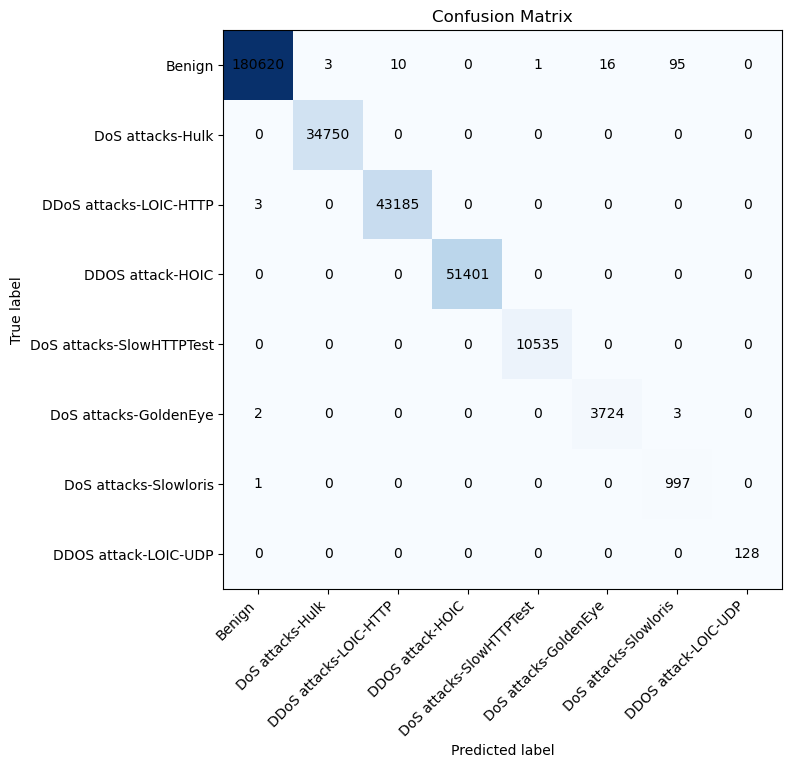

AUC-ROC: 1.0000
Test evaluation metrics saved at: outputs/2018/1dcnn/1dcnn_run1-0_5percent/test_evaluation_metrics.txt


In [ ]:
# ---------------------------
# 12. Evaluation on Test Set
# ---------------------------


# Ensure interactive plotting in VSCode
plt.ion()

model.eval()
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)

        y_true.extend(batch_y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

        if num_classes == 2:
            # Binary: probability of positive class (1)
            y_prob.extend(probs[:, 1].cpu().numpy())
        else:
            # Multiclass: collect full vectors
            y_prob.append(probs.cpu().numpy())

# — Classification Report —
target_names = [label_names[i] for i in range(num_classes)]
report = classification_report(
    y_true, y_pred,
    target_names=target_names,
    digits=4
)
print("Classification Report:\n", report)

# — Confusion Matrix & Plot —
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

fig, ax = plt.subplots(figsize=(8, 8))
# white→blue cmap
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

# Axis ticks and labels
ax.set_xticks(range(num_classes))
ax.set_yticks(range(num_classes))
ax.set_xticklabels(target_names, rotation=45, ha="right")
ax.set_yticklabels(target_names)

# Annotate each cell
for i in range(num_classes):
    for j in range(num_classes):
        ax.text(j, i, cm[i, j], ha="center", va="center")

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Confusion Matrix")
fig.tight_layout()

# Save and display
conf_mat_path = os.path.join(output_folder, "confusion_matrix.png")
plt.savefig(conf_mat_path, bbox_inches="tight")
print("Confusion matrix plot saved at:", conf_mat_path)
plt.show()

# — AUC‑ROC (separate) —
if num_classes == 2:
    auc = roc_auc_score(y_true, y_prob)
else:
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    auc = roc_auc_score(
        y_true_bin,
        np.vstack(y_prob),
        average='weighted',
        multi_class='ovr'
    )
print(f"AUC-ROC: {auc:.4f}")

# — Save all metrics to file —
test_eval_path = os.path.join(output_folder, "test_evaluation_metrics.txt")
with open(test_eval_path, "w") as f:
    f.write("Classification Report:\n")
    f.write(report + "\n")
    f.write("Confusion Matrix:\n")
    f.write(str(cm) + "\n\n")
    f.write(f"AUC-ROC: {auc:.4f}\n")

print("Test evaluation metrics saved at:", test_eval_path)